In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import scipy.io as sio
from keras.layers import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks  import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, auc
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks  import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
#dataPath = '../data/butter_feature_tensor_with_labels.mat'
#dataPath = '../data/csp_features_full_with_full_labels.csv'
dataPath = '../data/spectral_feat_tensor_full_with_full_labels_images.mat'
savePath = '../Results/CNN_2D_our/'

experiment = 'MultiClass_NC'

filename = savePath+'CNN_2D_results_'+experiment+'.mat'
plot_title = 'Multiclass Categorical Emotion Classification - NC'

nb_filters = [16, 32, 32, 64, 128]
kernel_size = 3
pool_size = 2
stride_size = 2
padding = 'same'
weight_decay = 0.000001
dense_layer_neuron_num = 128
epochs = 30
momentum =0.8

matContent = sio.loadmat(dataPath)
features = matContent['nc_feat_img']
labels = np.squeeze(matContent['nc_multi_labels'])
labels[labels < 0] = 0
features = np.swapaxes(features,1,3)
features = np.swapaxes(features,1,2)
labels[labels == 6] = 0
#labels = labels.astype(int)

#df = pd.read_csv(dataPath, header = None)
#features = df.iloc[1:,:-2].to_numpy()
#labels = df.iloc[1:,-1].to_numpy() # last but one column for PD vs NC

#dict_hvlv = {1:0, 2:1, 3:0, 4:0, 5:1, 6:0} #HVLV labels mapping dictionary
#labels = labels.map(dict_hvlv).to_numpy()
#labels[labels == 1] = 0
#labels[labels == 2] = 1
#labels[labels == 3] = 1
#labels[labels == 4] = 1
#labels[labels == 5] = 1
#labels[labels == 6] = 1
#labels[labels < 0]=0
#labels[labels == 6]=0

# randomise the sample sequence
rand_order = np.arange(features.shape[0])
np.random.shuffle(rand_order)
features = features[rand_order,]
labels = np.squeeze(labels[rand_order,])
class_num = np.size(np.unique(labels))
labels_categorical = np_utils.to_categorical(labels, class_num)
del matContent

In [3]:
labels_categorical

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [4]:
class_num

6

In [5]:
features.shape

(7412, 32, 32, 3)

In [6]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

In [7]:
def create_model(init_mode, activation, dropout_rate, optimizer, learn_rate):
#def create_model(activation):
  model = Sequential()
  model.add(Conv2D(filters=nb_filters[0], kernel_size=kernel_size, padding=padding,
                   activation=activation, input_shape=(features.shape[1], features.shape[2], features.shape[3]), trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[1], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  model.add(Conv2D(filters=nb_filters[2], kernel_size=kernel_size, padding=padding,
                   activation=activation, kernel_initializer=init_mode, trainable=True))
  model.add(AveragePooling2D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  #model.add(Conv1D(filters=nb_filters[3], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  #model.add(Conv1D(filters=nb_filters[4], kernel_size=kernel_size, padding=padding, activation=activation,
  #              kernel_initializer='he_normal'))
  #model.add(AveragePooling1D(pool_size=pool_size, strides=stride_size, padding=padding))
  # ####added by me#####
  model.add(Flatten())
  model.add(BatchNormalization(epsilon=0.001))
  model.add(Dense(dense_layer_neuron_num, kernel_initializer=init_mode, activation=activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(class_num))
  model.add(Activation('softmax'))
  #model.summary()
  #model.load_weights('Gender_notClean_HIweights.hdf5')
  #earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
  if optimizer == 'SGD':
    opt = SGD(learning_rate=learn_rate / 10 ** epochs, momentum = momentum, decay = weight_decay, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'Adam':
    opt = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  elif optimizer == 'RMSprop':
    opt = RMSprop(learning_rate=learn_rate, epsilon=1e-07)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


In [8]:
cnn_model = KerasClassifier(build_fn=create_model, verbose=0)

#batch_size = [16,32]
#epochs = [5,10,15]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softsign', 'relu', 'tanh', 'sigmoid', 'linear']
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]

learn_rate = [0.00001, 0.0001, 0.001]
optimizer = ['SGD', 'Adam','RMSprop']
#momentum = [0.8,0.9]
init_mode = ['he_normal','he_uniform']
activation = ['relu','tanh']
dropout_rate = [0.3,0.4,0.5]
foldNum = 10

p_grid = dict(init_mode=init_mode, dropout_rate=dropout_rate, activation=activation,
              optimizer=optimizer, learn_rate=learn_rate)
              #, momentum=momentum)
grid = GridSearchCV(estimator=cnn_model, param_grid=p_grid,
                    cv=foldNum, verbose=0)
# Standerdize
#feat_shape = features.shape
#features = np.reshape(features, (feat_shape[0], feat_shape[1]*feat_shape[2]))
#scaler = StandardScaler()
#scaler.fit(features)
#scaleFeatures = scaler.transform(features)
#scaleFeatures = np.reshape(scaleFeatures, (features.shape[0], 6, -1))

print('Performing Gridsearch')
grid_result = grid.fit(features,labels_categorical)
best_params = grid_result.best_params_
print('Best parameters:', best_params)
tf.keras.backend.clear_session()#to clear any previosuly obtiained models
estimator = create_model(init_mode=best_params.get('init_mode'), 
                         learn_rate=best_params.get('learn_rate'), 
                         optimizer=best_params.get('optimizer'), 
                         #momentum=best_params.get('momentum'), 
                         activation=best_params.get('activation'), 
                         dropout_rate=best_params.get('dropout_rate'))

Performing Gridsearch
Best parameters: {'activation': 'tanh', 'dropout_rate': 0.3, 'init_mode': 'he_uniform', 'learn_rate': 0.0001, 'optimizer': 'Adam'}


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

Epoch 5/30
188/188 - 3s - loss: 0.8971 - accuracy: 0.6632 - val_loss: 1.0210 - val_accuracy: 0.6357
Epoch 6/30
188/188 - 2s - loss: 0.8680 - accuracy: 0.6750 - val_loss: 0.9483 - val_accuracy: 0.6492
Epoch 7/30
188/188 - 3s - loss: 0.8612 - accuracy: 0.6790 - val_loss: 0.8969 - val_accuracy: 0.6717
Epoch 8/30
188/188 - 3s - loss: 0.8573 - accuracy: 0.6857 - val_loss: 0.9144 - val_accuracy: 0.6597
Epoch 9/30
188/188 - 2s - loss: 0.8388 - accuracy: 0.6883 - val_loss: 0.9278 - val_accuracy: 0.6657
Epoch 10/30
188/188 - 3s - loss: 0.8241 - accuracy: 0.6922 - val_loss: 0.8977 - val_accuracy: 0.6597
Epoch 11/30
188/188 - 3s - loss: 0.8097 - accuracy: 0.6970 - val_loss: 0.9401 - val_accuracy: 0.6432
Epoch 12/30
188/188 - 2s - loss: 0.8035 - accuracy: 0.7048 - val_loss: 0.9588 - val_accuracy: 0.6432
Epoch 13/30
188/188 - 3s - loss: 0.7947 - accuracy: 0.7035 - val_loss: 0.8835 - val_accuracy: 0.6927
Epoch 14/30
188/188 - 3s - loss: 0.7752 - accuracy: 0.7198 - val_loss: 0.9004 - val_accuracy: 0.

Epoch 1/30
188/188 - 3s - loss: 0.5048 - accuracy: 0.8204 - val_loss: 0.7985 - val_accuracy: 0.7335
Epoch 2/30
188/188 - 3s - loss: 0.4982 - accuracy: 0.8183 - val_loss: 0.8012 - val_accuracy: 0.7305
Epoch 3/30
188/188 - 2s - loss: 0.4875 - accuracy: 0.8241 - val_loss: 0.7743 - val_accuracy: 0.7350
Epoch 4/30
188/188 - 3s - loss: 0.4576 - accuracy: 0.8369 - val_loss: 0.7951 - val_accuracy: 0.7425
Epoch 5/30
188/188 - 3s - loss: 0.4747 - accuracy: 0.8266 - val_loss: 0.7416 - val_accuracy: 0.7695
Epoch 6/30
188/188 - 2s - loss: 0.4721 - accuracy: 0.8284 - val_loss: 0.8200 - val_accuracy: 0.7305
Epoch 7/30
188/188 - 3s - loss: 0.4562 - accuracy: 0.8376 - val_loss: 0.7852 - val_accuracy: 0.7470
Epoch 8/30
188/188 - 3s - loss: 0.4481 - accuracy: 0.8412 - val_loss: 0.8267 - val_accuracy: 0.7350
Epoch 9/30
188/188 - 2s - loss: 0.4653 - accuracy: 0.8309 - val_loss: 0.7622 - val_accuracy: 0.7575
Epoch 10/30
188/188 - 3s - loss: 0.4451 - accuracy: 0.8399 - val_loss: 0.8223 - val_accuracy: 0.7425

Epoch 1/30
188/188 - 2s - loss: 0.3467 - accuracy: 0.8729 - val_loss: 0.8782 - val_accuracy: 0.7545
Epoch 2/30
188/188 - 2s - loss: 0.3218 - accuracy: 0.8832 - val_loss: 0.8793 - val_accuracy: 0.7425
Epoch 3/30
188/188 - 3s - loss: 0.3293 - accuracy: 0.8809 - val_loss: 0.8364 - val_accuracy: 0.7470
Epoch 4/30
188/188 - 3s - loss: 0.3431 - accuracy: 0.8759 - val_loss: 0.8312 - val_accuracy: 0.7650
Epoch 5/30
188/188 - 2s - loss: 0.3260 - accuracy: 0.8812 - val_loss: 0.8896 - val_accuracy: 0.7485
Epoch 6/30
188/188 - 3s - loss: 0.3287 - accuracy: 0.8836 - val_loss: 0.8099 - val_accuracy: 0.7665
Epoch 7/30
188/188 - 3s - loss: 0.3030 - accuracy: 0.8912 - val_loss: 0.8628 - val_accuracy: 0.7515
Epoch 8/30
188/188 - 3s - loss: 0.3248 - accuracy: 0.8852 - val_loss: 0.7997 - val_accuracy: 0.7650
Epoch 9/30
188/188 - 3s - loss: 0.3173 - accuracy: 0.8896 - val_loss: 0.8459 - val_accuracy: 0.7500
Epoch 10/30
188/188 - 3s - loss: 0.3130 - accuracy: 0.8822 - val_loss: 0.8093 - val_accuracy: 0.7575

Epoch 1/30
188/188 - 2s - loss: 0.2499 - accuracy: 0.9080 - val_loss: 0.8623 - val_accuracy: 0.7620
Epoch 2/30
188/188 - 2s - loss: 0.2577 - accuracy: 0.9062 - val_loss: 0.8386 - val_accuracy: 0.7769
Epoch 3/30
188/188 - 2s - loss: 0.2620 - accuracy: 0.9085 - val_loss: 0.8395 - val_accuracy: 0.7665
Epoch 4/30
188/188 - 2s - loss: 0.2352 - accuracy: 0.9137 - val_loss: 0.8954 - val_accuracy: 0.7485
Epoch 5/30
188/188 - 1s - loss: 0.2221 - accuracy: 0.9189 - val_loss: 0.8449 - val_accuracy: 0.7740
Epoch 6/30
188/188 - 2s - loss: 0.2571 - accuracy: 0.9052 - val_loss: 0.8402 - val_accuracy: 0.7784
Epoch 7/30
188/188 - 2s - loss: 0.2422 - accuracy: 0.9109 - val_loss: 0.8283 - val_accuracy: 0.7680
Epoch 8/30
188/188 - 1s - loss: 0.2629 - accuracy: 0.9089 - val_loss: 0.8490 - val_accuracy: 0.7754
Epoch 9/30
188/188 - 2s - loss: 0.2587 - accuracy: 0.9047 - val_loss: 0.8066 - val_accuracy: 0.7740
Epoch 10/30
188/188 - 2s - loss: 0.2439 - accuracy: 0.9095 - val_loss: 0.8415 - val_accuracy: 0.7874

Epoch 1/30
188/188 - 2s - loss: 0.2069 - accuracy: 0.9262 - val_loss: 0.9161 - val_accuracy: 0.7680
Epoch 2/30
188/188 - 1s - loss: 0.2103 - accuracy: 0.9262 - val_loss: 0.9030 - val_accuracy: 0.7635
Epoch 3/30
188/188 - 2s - loss: 0.2057 - accuracy: 0.9267 - val_loss: 0.9229 - val_accuracy: 0.7620
Epoch 4/30
188/188 - 2s - loss: 0.2197 - accuracy: 0.9214 - val_loss: 0.8526 - val_accuracy: 0.7710
Epoch 5/30
188/188 - 1s - loss: 0.2068 - accuracy: 0.9242 - val_loss: 0.8646 - val_accuracy: 0.7874
Epoch 6/30
188/188 - 2s - loss: 0.2025 - accuracy: 0.9304 - val_loss: 0.8782 - val_accuracy: 0.7769
Epoch 7/30
188/188 - 2s - loss: 0.2016 - accuracy: 0.9275 - val_loss: 0.9091 - val_accuracy: 0.7575
Epoch 8/30
188/188 - 1s - loss: 0.1862 - accuracy: 0.9334 - val_loss: 0.9128 - val_accuracy: 0.7740
Epoch 9/30
188/188 - 2s - loss: 0.1988 - accuracy: 0.9289 - val_loss: 0.8735 - val_accuracy: 0.7650
Epoch 10/30
188/188 - 2s - loss: 0.2021 - accuracy: 0.9244 - val_loss: 0.9062 - val_accuracy: 0.7680

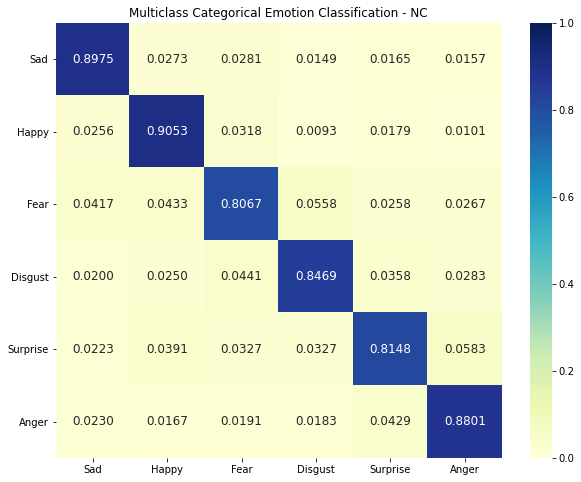

Mean and std of F1 MACRO is 0.8579 +- 0.0955
Mean and std of F1 WEIGHTED is 0.8582 +- 0.0954
Mean and std of accuracy is 0.8591 +- 0.0940


In [9]:
conf_mat = np.zeros((6,6))
f = 0
f1_MacroNet = np.zeros([foldNum,]) 
f1_weightedNet = np.zeros([foldNum,])
precisionNet = np.zeros([foldNum,])
recallNet = np.zeros([foldNum,])
accNet = np.zeros([foldNum,])

#channels = features.shape[2] # number of channels 14
kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

for train, test in kfold.split(features, labels):
    trainingFeatures = features[train,:,:, :]
    testFeatures = features[test,:,:, :]
    train_shape = trainingFeatures.shape
    test_shape = testFeatures.shape
    tf.keras.backend.clear_session()#to clear any previosuly obtiained models
    estimator.summary()
    estimator.fit(trainingFeatures, labels_categorical[train,:], batch_size=32, 
                epochs=epochs, verbose=2, validation_split=0.1)
    predicted_labelsNet = estimator.predict_classes(testFeatures, verbose=0)
    predicted_probsNet = estimator.predict_proba(testFeatures,batch_size=1,verbose=0)
    cm = confusion_matrix(labels[test,], predicted_labelsNet, labels=[1, 2, 3, 4, 5, 0])
    conf_mat = conf_mat+cm
    
    precisionNet[f] = precision_score(labels[test,], predicted_labelsNet, average='macro')
    recallNet[f] = recall_score(labels[test,], predicted_labelsNet, average='macro')
    f1_MacroNet[f] = f1_score(labels[test,], predicted_labelsNet, average='macro')
    f1_weightedNet[f] = f1_score(labels[test,], predicted_labelsNet, average='weighted')
    accNet[f] = accuracy_score(labels[test,], predicted_labelsNet)
    print(experiment + '_CNN: Fold %d : f1_macroscore: %.4f' % (f + 1, f1_MacroNet[f]))
    print(experiment + '_CNN: Fold %d : f1_weightedscore: %.4f' % (f + 1, f1_weightedNet[f]))
    print(experiment + '_CNN: Fold %d : acc: %.4f' % (f + 1, accNet[f]))
    f += 1

conf_mat /= conf_mat.sum(axis=1, keepdims = True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap='YlGnBu', annot = True, fmt='.4f', vmin=0, vmax=1, annot_kws = {'fontsize':12})
#ax.set_yticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_yticklabels(['PD', 'NC'], rotation = 0) # for spectral
#ax.set_yticklabels(['LA', 'HA'], rotation = 0)
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'], rotation = 0)
#ax.set_xticklabels(['LA', 'HA'], rotation = 0)
#ax.set_xticklabels(['NC', 'PD'], rotation = 0) # for CSP and IIR
#ax.set_xticklabels(['PD', 'NC'], rotation = 0) # for spectral

ax.set_title(plot_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

print('Mean and std of F1 MACRO is %.4f +- %.4f' % (np.mean(f1_MacroNet), np.std(f1_MacroNet)))
print('Mean and std of F1 WEIGHTED is %.4f +- %.4f' % (np.mean(f1_weightedNet), np.std(f1_weightedNet)))
print('Mean and std of accuracy is %.4f +- %.4f' % (np.mean(accNet), np.std(accNet)))

# Save results
sio.savemat(filename, {'precisionNet': precisionNet,'recallNet': recallNet, 'f1_MacroNet': f1_MacroNet,
                       'f1_weightedNet':f1_weightedNet,'accNet':accNet, 'conf_mat':conf_mat,
                      'best_params':best_params, 'experiment':experiment,'nb_filters':nb_filters,
                       'kernel_size':kernel_size, 'pool_size':pool_size, 'stride_size':stride_size,'padding':padding,
                       'weight_decay':weight_decay, 'dense_layer_neuron_num':dense_layer_neuron_num,'epochs':epochs})